In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Importing all the necessary libraries

In [4]:
import numpy as np
from nltk.tokenize import word_tokenize
import pandas as pd
import glob 
import librosa
import imageio
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from scipy.stats import multivariate_normal
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import math
import random
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    

Reading movie reviews data

In [5]:
path = open('drive/MyDrive/Data/Reviews.txt','r')
textFile = path.readlines()

Separating movie reviews labels

In [6]:
labels = []
noLabelReview = []
for i in textFile:
  i = i.strip()
  var = i.split("\t")
  labels.append(int(var[1]))
  noLabelReview.append(var[0].strip())

copyOfLables = []
for i in labels:
  copyOfLables.append(i)
labels = np.array(labels)
# noLabelReview

Splitting data into test and train:

In [7]:
labelTrain = labels[0:750]
labelTest = labels[750:1000]
noLabelReviewTrain = noLabelReview[0:750]
noLabelReviewTest = noLabelReview[750:1000]

Vectorizing train and validtion data using TFIDF vectorizer

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(noLabelReviewTrain)
# vectorizer.get_feature_names_out()
X = X.toarray()

Doing PCA with 30 components 

In [9]:
pca = PCA(n_components = 30)
pcaAll = pca.fit_transform(X)


DDividing the test and validation data randomly. Also vectorizing the TFIDF features for test data 

In [10]:
from sklearn.utils import shuffle
pcaAll, labelTrain = shuffle(pcaAll, labelTrain)
pcaTrain = pcaAll[0:625]
targetTrain = labelTrain[0:625]
pcaValidation = pcaAll[625:750]
targetValidation = labelTrain[625:750]
# vectorizer = TfidfVectorizer()
Y = vectorizer.transform(noLabelReviewTest)
# vectorizer.get_feature_names_out()
Y = Y.toarray()
pcaTest = pca.transform(Y)

Sigmoid function:

In [11]:
def sigmoid(x):
  return (1 / (1 + math.exp(-x)))

Main code for logistic regression model and logistic regression with regularization.

In [12]:
class LogisticRegression1:
  def __init__(self, learningRate, batchSize, data, target, validationData, validationTarget, epochs, lambda1 = 1):
    self.learningRate = learningRate
    self.batchSize = batchSize
    self.data = data
    self.target = target
    self.validationData = validationData
    self.validationTarget = validationTarget
    self.epochs = epochs
    self.W = np.random.rand(data.shape[1], 1)
    self.b = random.random()
    self.batches = []
    self.targets = []
    self.lossFunction = []
    self.lambda1 =  lambda1                           #Add value of Lambda here  
    # self.ctr = 0
  
  #Making batches of input batch size
  def batchMaker(self):
    j=0
    for i in range(0,self.data.shape[0]//self.batchSize):
      j=j+1
      self.batches.append(self.data[i*self.batchSize:(i+1)*self.batchSize])
      self.targets.append(self.target[i*self.batchSize:(i+1)*self.batchSize])
    self.batches.append(self.data[j*self.batchSize:self.data.shape[0]])
    self.targets.append(self.target[j*self.batchSize:self.data.shape[0]])
    self.batches = np.array(self.batches)
    self.targets = np.array(self.targets)  
    return self.batches
  
  #forward pass for logistic regression without regularization
  def forwardPass1(self, batch, t):
    Y = []
    batch = np.array(batch)
    gradientW = [0]*30
    gradientB = 0
    #calculating Y
    for i in range(batch.shape[0]):
      Y.append(sigmoid(np.dot((self.W).T , batch[i])+self.b))
    #Calculating gradient terms 
    for i in range(batch.shape[0]):
      gradientB += (Y[i]-t[i])
      for j in range(30):
        gradientW[j] += (Y[i]-t[i])*batch[i][j]
    # print(gradientW,gradientB)
    return gradientW,gradientB

#Forward pass for regularization logistic regression
  def forwardPass2(self, batch, t):
      Y = []
      batch = np.array(batch)
      gradientW = [0]*30
      gradientB = 0
      #calculating Y
      for i in range(batch.shape[0]):
        Y.append(sigmoid(np.dot((self.W).T , batch[i])+self.b))
      #Calculating gradient terms 
      for i in range(batch.shape[0]):
        gradientB += (Y[i]-t[i])
        for j in range(30):
          gradientW[j] += (Y[i]-t[i])*batch[i][j] 
      # print(gradientW,gradientB)
      for j in range(30):
          gradientW[j] += self.lambda1 * self.W[j]
      return gradientW,gradientB

  def backwardPass(self, Ew, Eb):
    Ew = np.array(Ew)
    # print(Ew.shape)
    self.W = self.W - self.learningRate * Ew
    self.b = self.b - self.learningRate * Eb

#Calculating loss using both train and validation data
  def lossCalculate(self, dataset, t):
    lossFunction = 0
    for i in range(dataset.shape[0]):
      # print(self.W)
      t1 = np.dot((self.W).T, dataset[i]) + self.b
      t1 = sigmoid(t1)
      temp = math.log(t1)
      temp2= math.log(1-t1)
      lossFunction += t[i]*temp + (1-t[i])*temp2
    return lossFunction

#For plotting the loss for train data 
  def plotterTrain(self, v):
    v = -1*np.array(v)
    u = np.arange(start=1, stop=21, step=1)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss Function')
    plt.title('Loss function for Train data')
    plt.plot(u,v)
    plt.show()
#For plotting the loss for validation data 
  def plotterValidation(self, v):
    v = -1*np.array(v)
    u = np.arange(start=1, stop=21, step=1)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss Function')
    plt.title('Loss function for Validation data')
    plt.plot(u,v)
    plt.show()
    # return 

#batch stochastic gradient descent for no regularization logistic regression 
  def stochasticGradientDescent1(self):
    for i in range(self.batches.shape[0]):             #Check this 
      Ew,Eb =self.forwardPass1(self.batches[i],self.targets[i])
      # print(Ew,Eb)                        #Ew has both +ve and -ve values
      Ew = np.reshape(Ew, (30,1))
      self.backwardPass(Ew,Eb)

#batch stochastic gradient descent for no regularization logistic regression 
  def stochasticGradientDescent2(self):
    for i in range(self.batches.shape[0]):             #Check this 
      Ew,Eb =self.forwardPass2(self.batches[i],self.targets[i])
      # print(Ew,Eb)                        #Ew has both +ve and -ve values
      Ew = np.reshape(Ew, (30,1))
      self.backwardPass(Ew,Eb)

#For training no regularization logistic regression model
  def trainNoRegularization(self):
    #For making batches
    self.batchMaker()
    #For plotting and iteration on epoch
    trainPlot = []
    validationPlot = []
    for i in range(self.epochs):
      self.stochasticGradientDescent1()
      trainPlot.append(self.lossCalculate(self.data, self.target))
      validationPlot.append(self.lossCalculate(self.validationData, self.validationTarget))
    # print(len(trainPlot))
    self.plotterTrain(trainPlot)
    self.plotterValidation(validationPlot)
  
#For training logistic regression model with regularization
  def trainRegularization(self):
    #For making batches
    self.batchMaker()
    #For plotting and iteration on epoch
    trainPlot = []
    validationPlot = []
    for i in range(self.epochs):
      self.stochasticGradientDescent2()
      trainPlot.append(self.lossCalculate(self.data, self.target))
      validationPlot.append(self.lossCalculate(self.validationData, self.validationTarget))
    # print(len(trainPlot))
    if self.lambda1 != 0:
      self.plotterTrain(trainPlot)
      self.plotterValidation(validationPlot)
    return trainPlot[19],validationPlot[19]
    


#For prediction the value of test data
  def predict(self, data):
    prediction = []
    for i in range(0, data.shape[0]):
      tempVar1 = sigmoid(np.dot((self.W).T , data[i]) + self.b)
      if (tempVar1 >= 0.5):
        prediction.append(1)
      else:
        prediction.append(0)
    return prediction

For calculating the model accuracy using test data and labels

In [13]:
def accuracy(A, B):
  ctr = 0;
  for i in range(0, len(A)):
    if(A[i] == B[i]):
      ctr += 1
  return (ctr / len(A)) * 100

Defining parameters for Logistic regression:

In [18]:
batch = [32, 64, 128]
learningRate = [1e-3, 1e-2, 1e-1]
regularization =[0, 1e-2, 1e-1, 1]

Running logistic regression model without regularization over differnt model parameters(batch size, learning rate)

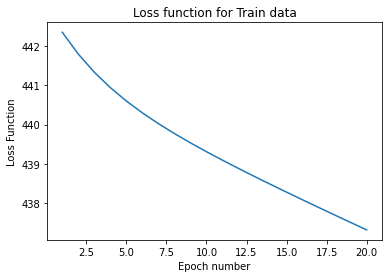

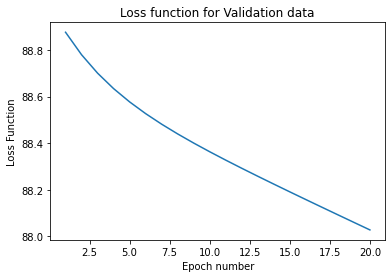

Batch Size: 32, Learning Rate: 0.001
Accuracy : 46.400000000000006


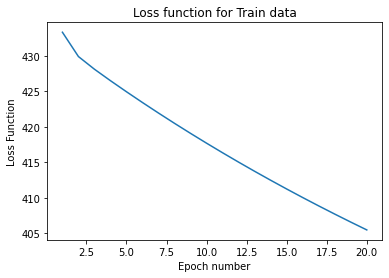

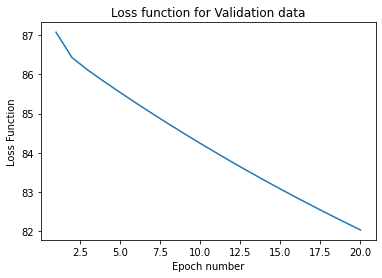

Batch Size: 32, Learning Rate: 0.01
Accuracy : 52.800000000000004


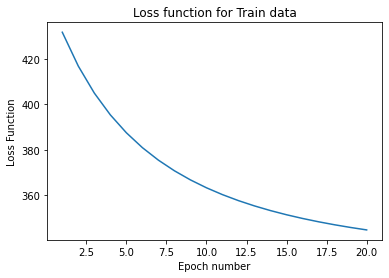

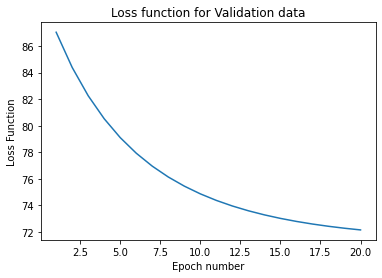

Batch Size: 32, Learning Rate: 0.1
Accuracy : 66.4


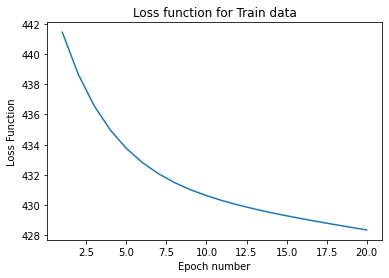

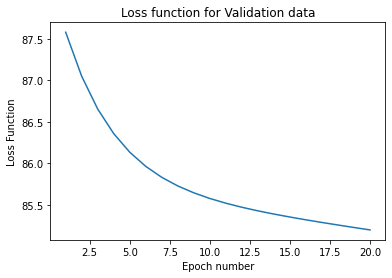

Batch Size: 64, Learning Rate: 0.001
Accuracy : 44.800000000000004


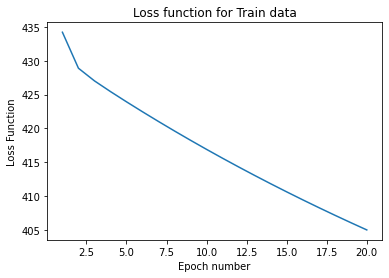

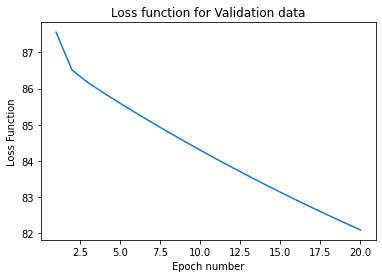

Batch Size: 64, Learning Rate: 0.01
Accuracy : 53.6


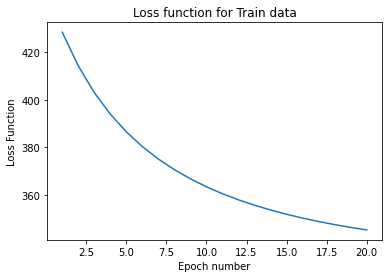

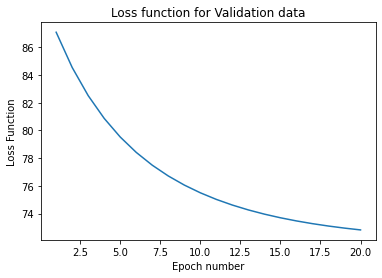

Batch Size: 64, Learning Rate: 0.1
Accuracy : 66.4


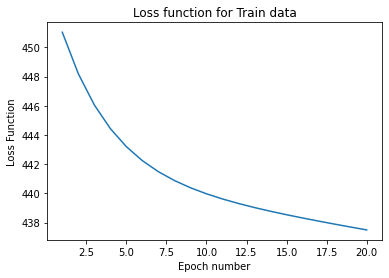

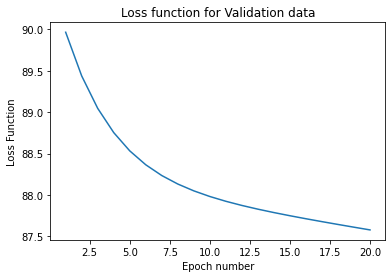

Batch Size: 128, Learning Rate: 0.001
Accuracy : 44.4


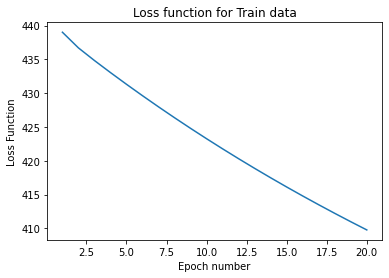

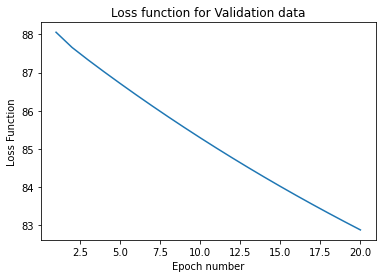

Batch Size: 128, Learning Rate: 0.01
Accuracy : 49.2


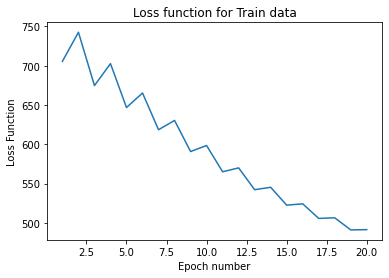

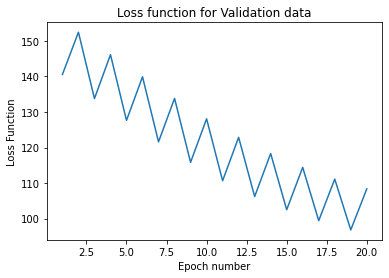

Batch Size: 128, Learning Rate: 0.1
Accuracy : 66.0
Maximum Accuracy: 66.4, Avg Accuracy: 54.44444444444445


In [19]:
accuracies = []
for i in batch:
    for j in learningRate:
        a = LogisticRegression1(j, i, pcaTrain, targetTrain, pcaValidation, targetValidation, 20)
        a.trainNoRegularization()
        predictedlabel = a.predict(pcaTest)
        acc = accuracy(predictedlabel, labelTest)
        accuracies.append(acc)
        print(f'Batch Size: {i}, Learning Rate: {j}')
        print(f'Accuracy : {acc}')
        # print("")
print(f'Maximum Accuracy: {max(accuracies)}, Avg Accuracy: {sum(accuracies)/9}')

Running logistic regression model with regularization over differnt model parameters(batch size, learning rate,regularization coefficient)

Accuracy : 44.0
Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 0


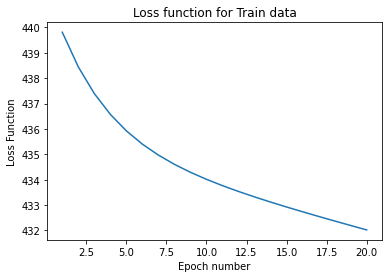

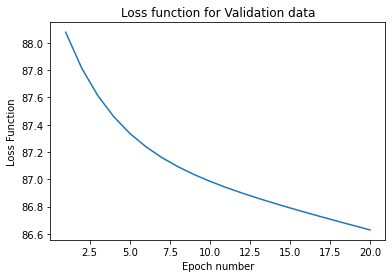

Accuracy : 45.6
Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 0.01


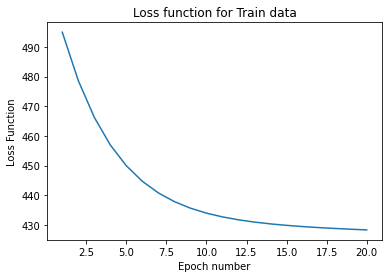

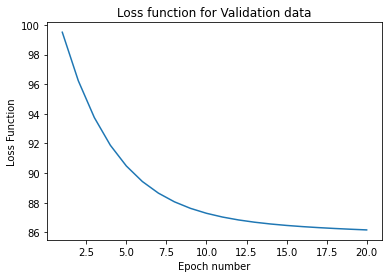

Accuracy : 48.8
Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 0.1


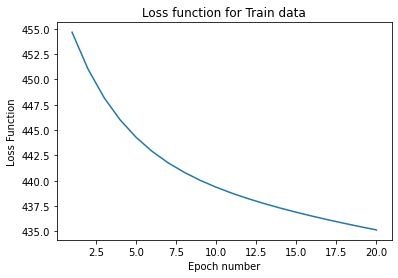

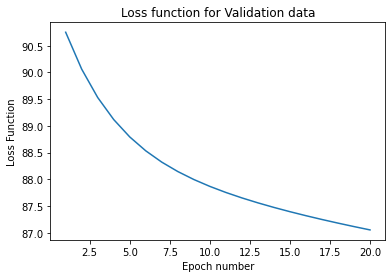

Accuracy : 40.400000000000006
Batch Size: 32, Learning Rate: 0.001, Regularization Parameter: 1
Accuracy : 49.6
Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 0


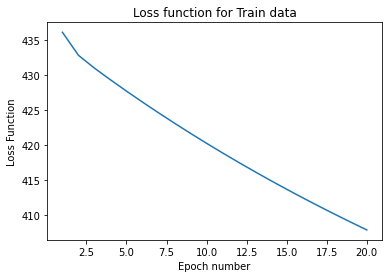

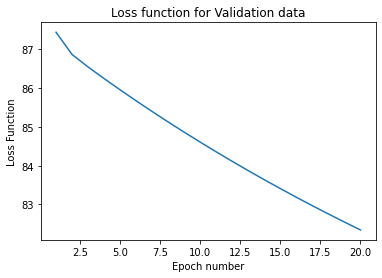

Accuracy : 51.6
Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 0.01


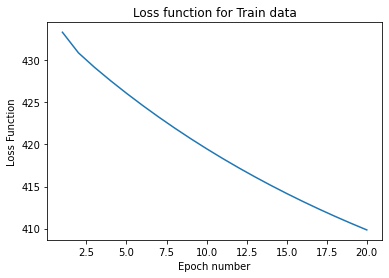

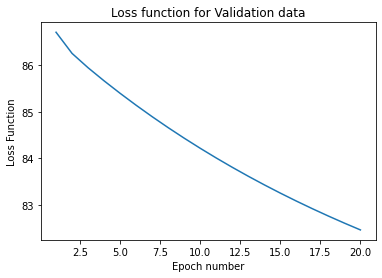

Accuracy : 52.0
Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 0.1


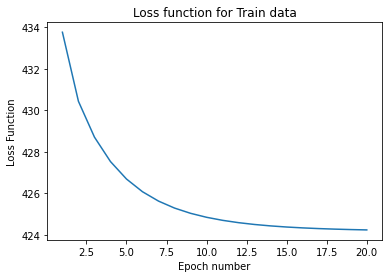

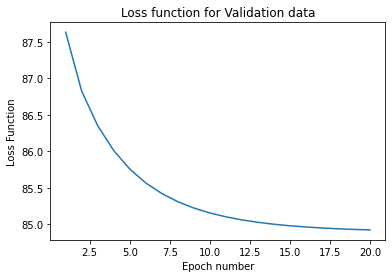

Accuracy : 38.800000000000004
Batch Size: 32, Learning Rate: 0.01, Regularization Parameter: 1
Accuracy : 66.0
Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 0


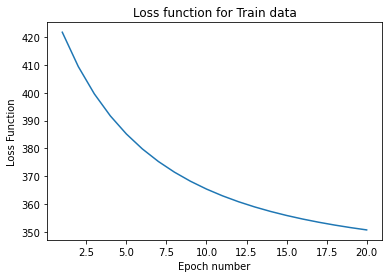

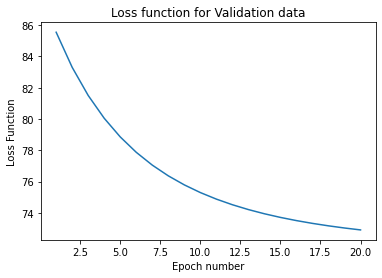

Accuracy : 66.8
Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 0.01


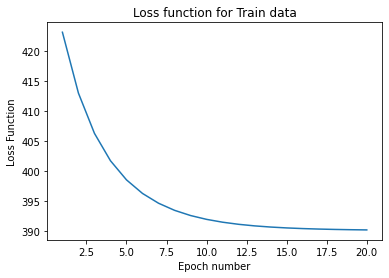

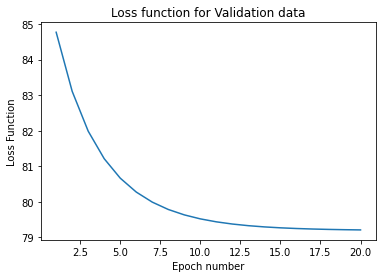

Accuracy : 67.60000000000001
Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 0.1


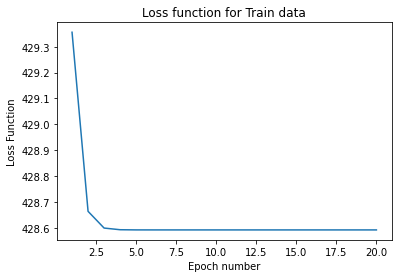

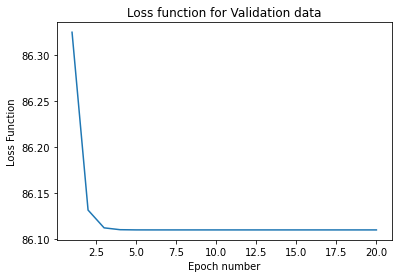

Accuracy : 62.8
Batch Size: 32, Learning Rate: 0.1, Regularization Parameter: 1
Accuracy : 46.800000000000004
Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 0


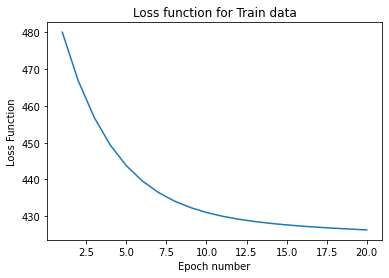

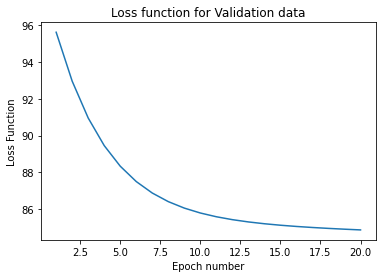

Accuracy : 46.0
Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 0.01


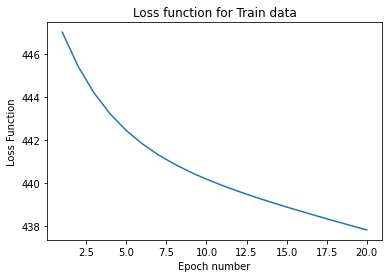

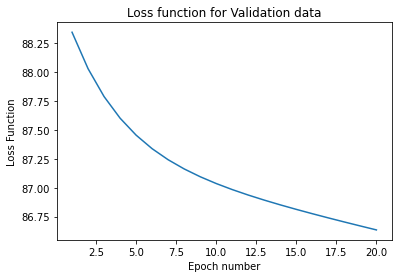

Accuracy : 41.6
Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 0.1


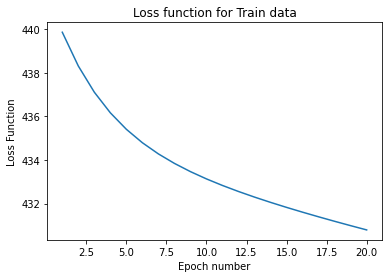

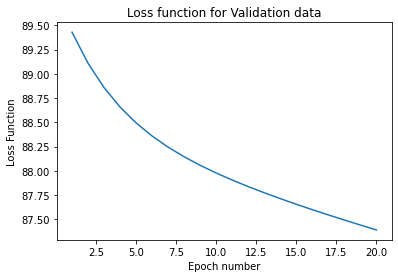

Accuracy : 44.800000000000004
Batch Size: 64, Learning Rate: 0.001, Regularization Parameter: 1
Accuracy : 54.0
Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 0


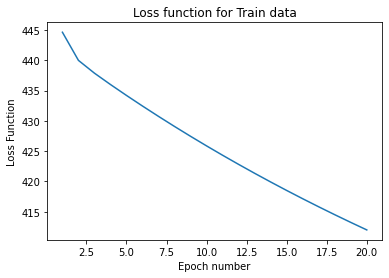

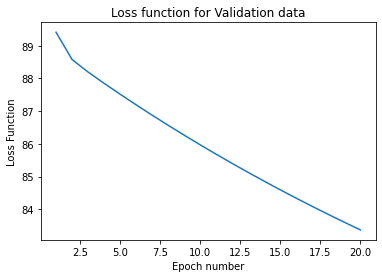

Accuracy : 51.2
Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 0.01


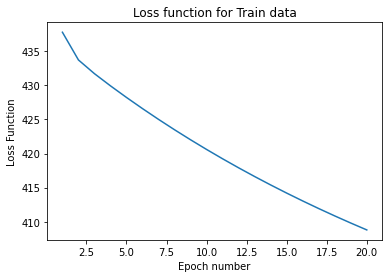

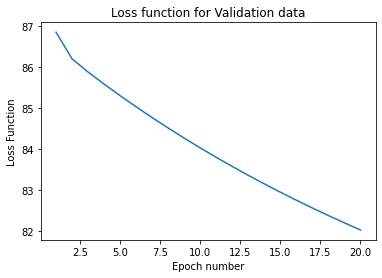

Accuracy : 51.2
Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 0.1


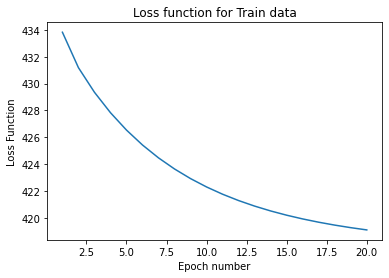

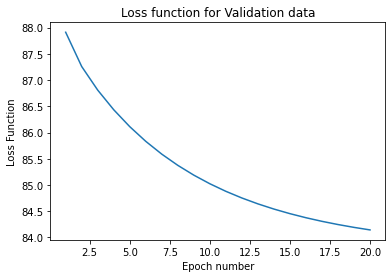

Accuracy : 44.4
Batch Size: 64, Learning Rate: 0.01, Regularization Parameter: 1
Accuracy : 66.0
Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 0


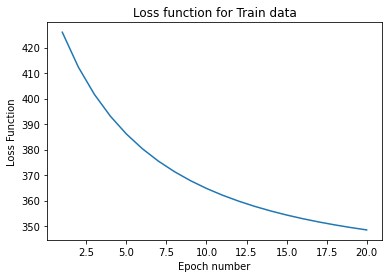

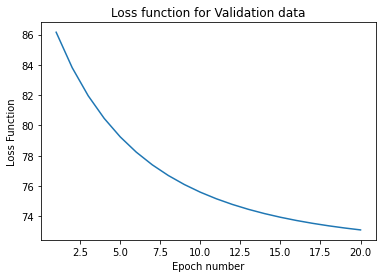

Accuracy : 66.4
Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 0.01


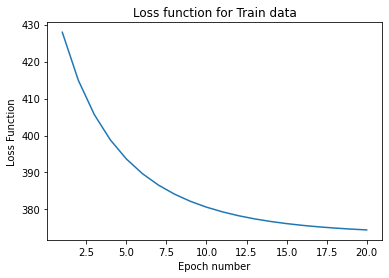

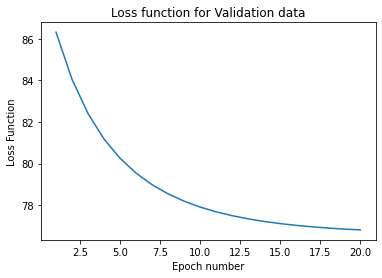

Accuracy : 66.8
Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 0.1


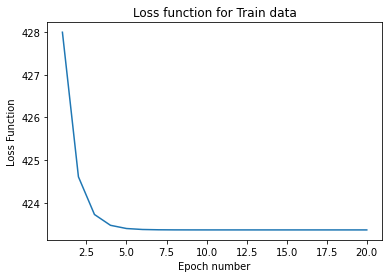

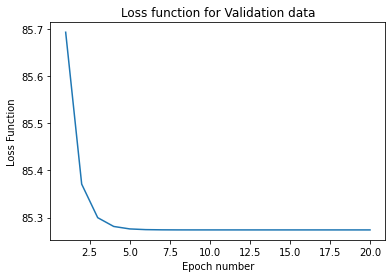

Accuracy : 64.0
Batch Size: 64, Learning Rate: 0.1, Regularization Parameter: 1
Accuracy : 45.2
Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 0


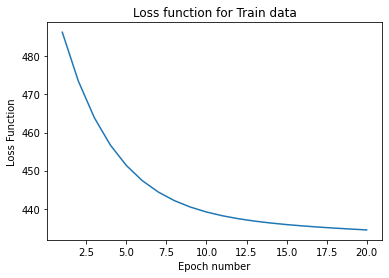

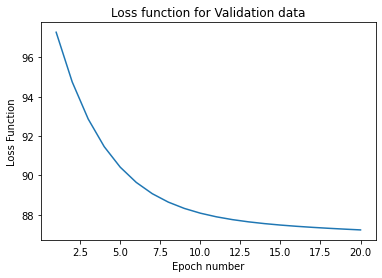

Accuracy : 44.800000000000004
Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 0.01


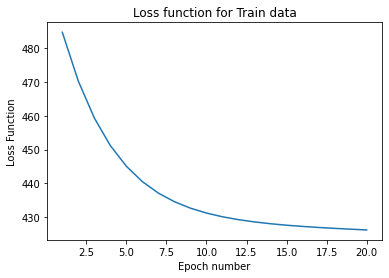

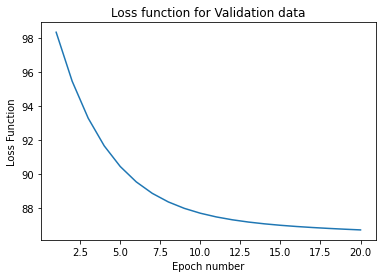

Accuracy : 50.4
Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 0.1


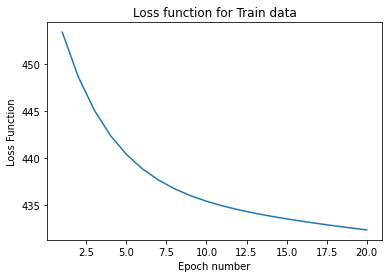

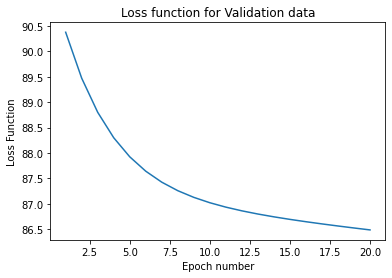

Accuracy : 46.0
Batch Size: 128, Learning Rate: 0.001, Regularization Parameter: 1
Accuracy : 51.2
Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 0


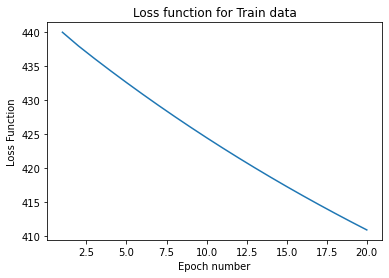

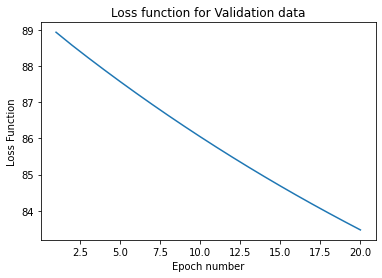

Accuracy : 54.0
Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 0.01


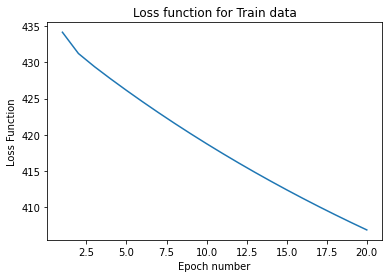

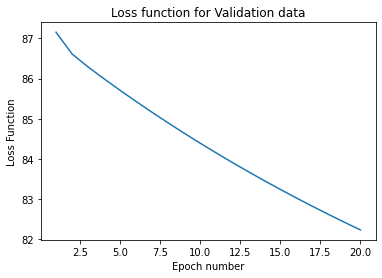

Accuracy : 52.0
Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 0.1


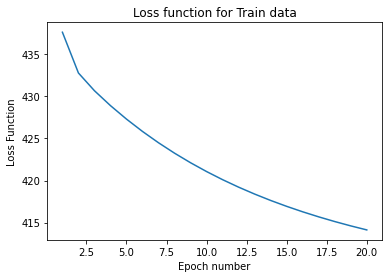

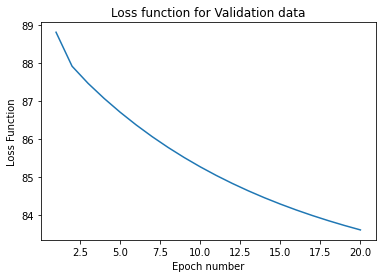

Accuracy : 50.0
Batch Size: 128, Learning Rate: 0.01, Regularization Parameter: 1
Accuracy : 66.8
Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 0


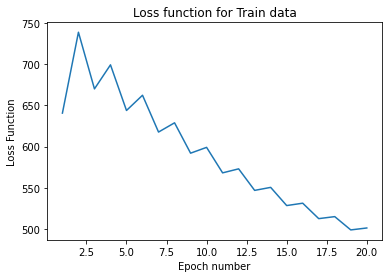

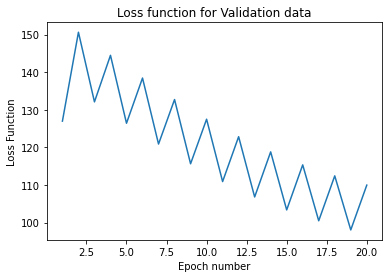

Accuracy : 66.4
Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 0.01


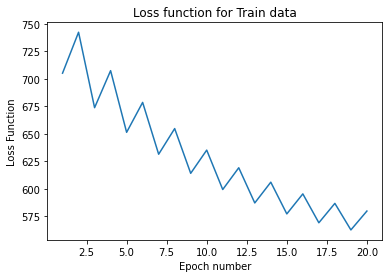

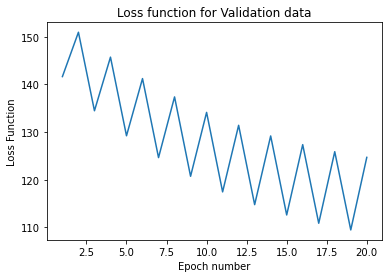

Accuracy : 62.0
Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 0.1


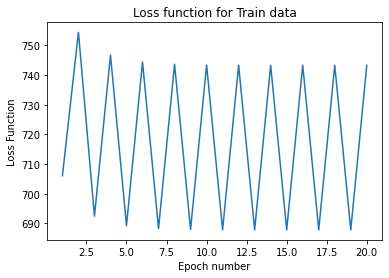

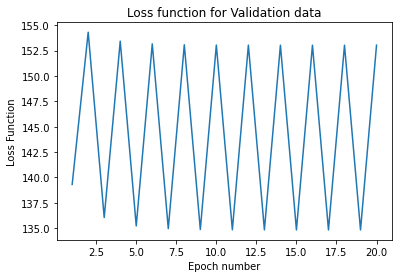

Accuracy : 61.199999999999996
Batch Size: 128, Learning Rate: 0.1, Regularization Parameter: 1
Maximum Accuracy: 67.60000000000001, Avg Accuracy: 71.3777777777778


In [20]:
accuracies = []
error =[]
for i in batch:
    for j in learningRate:
        for k in regularization:
            b = LogisticRegression1(j, i, pcaTrain, targetTrain, pcaValidation, targetValidation, 20, k)
            trn,val = b.trainRegularization()
            error.append([i,j,k,trn,val])
            predictedlabelReg = b.predict(pcaTest)
            acc = accuracy(predictedlabelReg, labelTest)
            accuracies.append(acc)
            print(f'Accuracy : {acc}')
            print(f'Batch Size: {i}, Learning Rate: {j}, Regularization Parameter: {k}')
print(f'Maximum Accuracy: {max(accuracies)}, Avg Accuracy: {sum(accuracies)/27}')

Batch size 128, learning rate 0.1 gives underfitting 


Making varince vs bias graph:

In [21]:
# print(error)

[[32, 0.001, 0, -436.2001404430313, -87.39669563892684], [32, 0.001, 0.01, -432.0214161041963, -86.6290601893169], [32, 0.001, 0.1, -428.3150223455198, -86.16485688930865], [32, 0.001, 1, -435.14613030981377, -87.05551426865003], [32, 0.01, 0, -408.6702340521363, -82.2299031524706], [32, 0.01, 0.01, -407.8493145358829, -82.34323135983927], [32, 0.01, 0.1, -409.84247659845164, -82.45974041329269], [32, 0.01, 1, -424.2431101324759, -84.91981884826923], [32, 0.1, 0, -344.1261688169391, -72.10042721245011], [32, 0.1, 0.01, -350.64787963677435, -72.91582804569627], [32, 0.1, 0.1, -390.1698427846381, -79.20555134945634], [32, 0.1, 1, -428.5923234815711, -86.11004056151957], [64, 0.001, 0, -431.6887492154982, -86.48980548029648], [64, 0.001, 0.01, -426.28520102290264, -84.87149037949611], [64, 0.001, 0.1, -437.80980901557086, -86.63510456190382], [64, 0.001, 1, -430.79502049433614, -87.39055331200234], [64, 0.01, 0, -401.62450797164945, -80.5029326287169], [64, 0.01, 0.01, -412.00739885224846

Making training error vs validation error graph

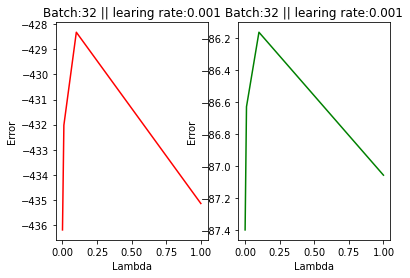

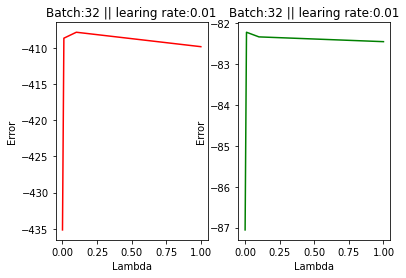

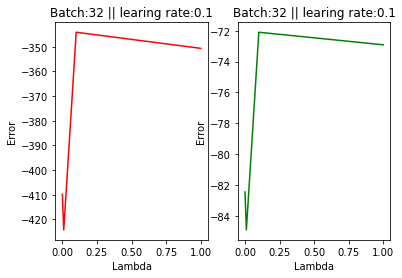

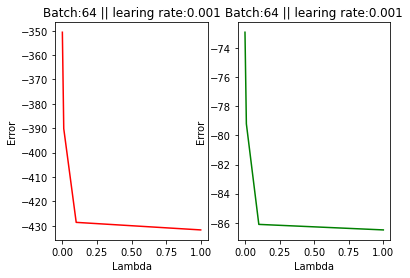

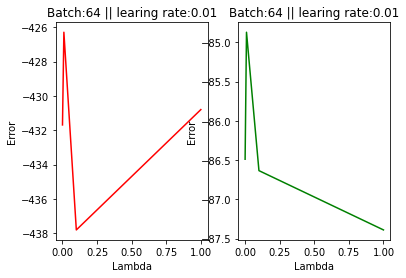

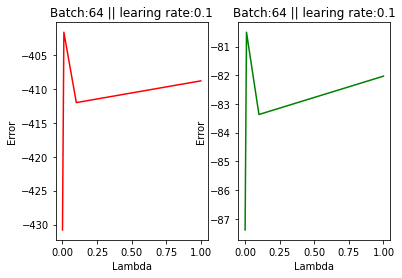

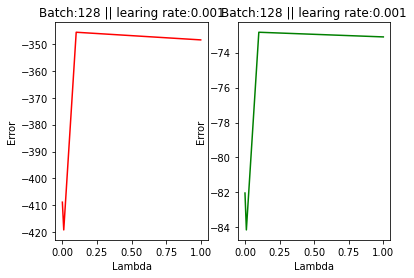

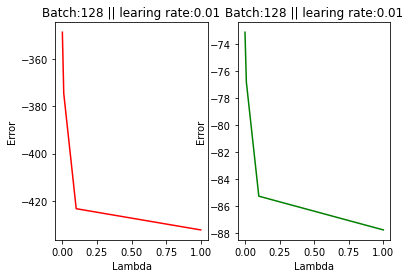

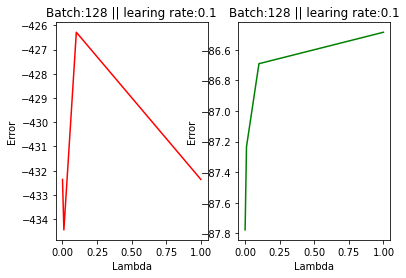

In [30]:
for i in range(len(batch)):
    for j in range(len(learningRate)):
      x=[]
      y1=[]
      y2=[]
      for k in range(len(regularization)):
        x.append(regularization[k])
        y1.append(error[(i*9)+(j*3)+k][3])
        y2.append(error[(i*9)+(j*3)+k][4])
      plt.subplot(1, 2, 1)
      plt.xlabel('Lambda')
      plt.ylabel('Error')
      plt.title('Batch:{} || learing rate:{}'.format(batch[i],learningRate[j]))
      plt.plot(x, y1, label = 'Training', color="red")
      # plt.plot(x, y2, label = 'Validation', color="green")
      
      plt.subplot(1, 2, 2)
      plt.xlabel('Lambda')
      plt.ylabel('Error')
      plt.title('Batch:{} || learing rate:{}'.format(batch[i],learningRate[j]))
      plt.plot(x, y2, label = 'Validation', color="green")
      plt.show()

Overfitting: for batch 128, learning rate 0.1 training error decreases and validation error increases with lambda. 



Underfitting: for batch 128, learning rate 0.001 : training error increases and validation error increases with lambda. 